In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import sklearn

In [2]:
df_featuresonly = pd.read_excel("wc_data_ready_featuresonly.xlsx", engine="openpyxl")
df_featurestarget = pd.read_excel("wc_data_ready_features_target.xlsx", engine="openpyxl")

(target classes)  
0 is cloudy  
1 is rainy  
2 is snowy  
3 is sunny

As decided on 10.1, to make the prediction more meaningful I'll now remove the cloud cover and visibility features, and continue that way.  

In [3]:
df_featuresonly.drop(
    ["Visibility (km)", "Cloud Cover_clear", "Cloud Cover_cloudy", "Cloud Cover_overcast", 
     "Cloud Cover_partly cloudy"], axis=1, inplace=True)
df_featurestarget.drop(
    ["Visibility (km)", "Cloud Cover_clear", "Cloud Cover_cloudy", "Cloud Cover_overcast", 
     "Cloud Cover_partly cloudy"], axis=1, inplace=True)

In [4]:
df_featuresonly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12318 entries, 0 to 12317
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Temperature (Celsius)       12318 non-null  float64
 1   Precipitation (%)           12318 non-null  float64
 2   Wind Speed (km/h)           12318 non-null  float64
 3   Atmospheric Pressure (hPa)  12318 non-null  float64
 4   Humidity (%)                12318 non-null  float64
 5   Season_Autumn               12318 non-null  bool   
 6   Season_Spring               12318 non-null  bool   
 7   Season_Summer               12318 non-null  bool   
 8   Season_Winter               12318 non-null  bool   
 9   Location_coastal            12318 non-null  bool   
 10  Location_inland             12318 non-null  bool   
 11  Location_mountain           12318 non-null  bool   
dtypes: bool(7), float64(5)
memory usage: 565.5 KB


In [5]:
from sklearn.model_selection import train_test_split
X = df_featuresonly
y = df_featurestarget["Weather Type"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.8, random_state=40)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=40)


Obviously can just switch to other branch to see this, but for quick comparison I'll nevertheless include here:  

  Default config: lbfgs solver, L2 penalty (sklearn default), C (inverse of regularization strength, λ) 1.0 (sklearn default). With the default config, here are some scores.
  
  * class 0 F1 score 72.9%  
  * class 1 F1 score 79.3%  
  * class 2 F1 score 87.2%  
  * class 3 F1 score 82.1%  
  * accuracy 80.5%
  * number of iterations to convergence 50

------------------------------------------------------------------------------------------------

Switched to Newton-CG solver. F1 scores and accuracy a smidge better (not significant); number of iterations to convergence 6. Very small compared with other solver!  
What does this tell us?  
Also no change when C increased to 5.  
Negligible change when C decreased to 0.5.  
Probably need to try random search and grid search -- and otherwise possibly attempt better scaling...

------------------------------------------------------------------------------------------------

Switched to sag solver. Negligible change to eval metrics, I think, BUT it does not converge! Needed more than 100 iterations. So need to check if, with convergence, the other metrics will change. And then try saga solver. 

------------------------------------------------------------------------------------------------

Not going to do any more of this validation until I've employed cross-validation, because I don't want to cause overfitting of model to val set. I'll do CV in main branch, I think.  


In [6]:
# Multi_class parameter is deprecated. I think the function automatically selects multinomial LogReg when 
# number of target classes >= 3 (documentation) 

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='sag', random_state=40)
model.fit(X_train, y_train)

C:\Users\Matthew\miniconda3\envs\synthweatherproj24ML_envCLONE\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(random_state=40, solver='sag')

In [7]:
from sklearn.metrics import classification_report 

y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred, output_dict=True))

# Note: the documentation says, if you specify dict output, you cannot round the values with the rounding parameter 

{'0': {'precision': 0.7344827586206897, 'recall': 0.7244897959183674, 'f1-score': 0.7294520547945206, 'support': 294.0}, '1': {'precision': 0.8145695364238411, 'recall': 0.7735849056603774, 'f1-score': 0.7935483870967742, 'support': 318.0}, '2': {'precision': 0.8369230769230769, 'recall': 0.9096989966555183, 'f1-score': 0.8717948717948718, 'support': 299.0}, '3': {'precision': 0.8285714285714286, 'recall': 0.8130841121495327, 'f1-score': 0.8207547169811321, 'support': 321.0}, 'accuracy': 0.8051948051948052, 'macro avg': {'precision': 0.8036367001347591, 'recall': 0.8052144525959489, 'f1-score': 0.8038875076668247, 'support': 1232.0}, 'weighted avg': {'precision': 0.804531227425887, 'recall': 0.8051948051948052, 'f1-score': 0.8043313490454329, 'support': 1232.0}}


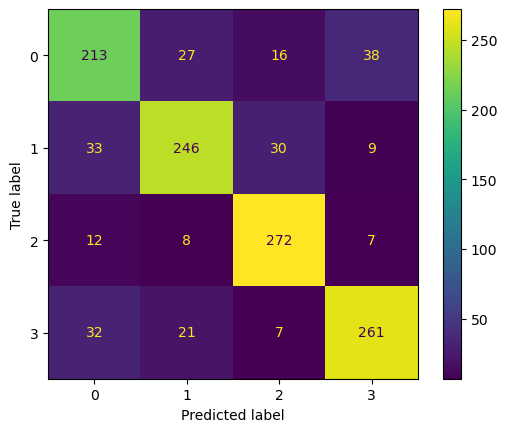

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)

In [9]:
model.n_iter_

array([100])

In [10]:
model.coef_

array([[ 0.97403803, -1.96389111, -0.12852468,  0.01770031,  0.12033221,
         0.17395123,  0.21280566,  0.10376305, -0.41185982,  0.20343139,
        -0.05053464, -0.07423665],
       [ 0.99719598,  3.32209667,  0.5088693 , -0.01640791,  0.49606258,
         0.13476322,  0.18005337,  0.21505255, -0.5963358 ,  0.30166942,
        -0.13867595, -0.22946012],
       [-6.18535227,  2.71585084,  0.18170308, -0.06654866,  0.2483916 ,
        -0.44105329, -0.52052206, -0.56459987,  1.53765233, -0.68667089,
         0.30276401,  0.39538398],
       [ 4.21411827, -4.07405639, -0.56204771,  0.06525626, -0.86478639,
         0.13233884,  0.12766303,  0.24578428, -0.52945671,  0.18157008,
        -0.11355342, -0.09168721]])

V v informative: correlation coefficient between each feature and target. 

In [11]:
model.intercept_

array([ 1.64164047, -1.37681252,  0.20759296, -0.47242091])